In [ ]:
!pip install optuna
!pip install lazypredict
!pip install catboost
!pip install mlxtend
!pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model, cluster, datasets
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsRegressor
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold
from sklearn import metrics
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from catboost import CatBoostRegressor, Pool, cv

from hyperopt import STATUS_OK
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin, space_eval

import optuna
from optuna.samplers import TPESampler

import time
import warnings
import os
import xgboost
import pickle
import requests

pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', '{:.8f}'.format)

print("Done")

Done


In [ ]:
df_train = pd.read_csv("https://raw.githubusercontent.com/kmyafi/CO2-Emissions-Predict/main/data/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/kmyafi/CO2-Emissions-Predict/main/data/test.csv")
print("Done")

Done


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54937 entries, 0 to 54936
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Id                     54937 non-null  int64 
 1   Make                   54937 non-null  object
 2   Vehicle Class          54398 non-null  object
 3   Engine Size(L)         53544 non-null  object
 4   Cylinders              53739 non-null  object
 5   Transmission           54527 non-null  object
 6   Fuel Type              54391 non-null  object
 7   Fuel Consumption City  53369 non-null  object
 8   Fuel Consumption Hwy   53236 non-null  object
 9   Fuel Consumption Comb  53263 non-null  object
 10  CO2 Emissions(g/km)    54937 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 4.6+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23545 entries, 0 to 23544
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Id                     23545 non-null  int64 
 1   Make                   23545 non-null  object
 2   Vehicle Class          23326 non-null  object
 3   Engine Size(L)         22913 non-null  object
 4   Cylinders              23039 non-null  object
 5   Transmission           23382 non-null  object
 6   Fuel Type              23324 non-null  object
 7   Fuel Consumption City  22861 non-null  object
 8   Fuel Consumption Hwy   22824 non-null  object
 9   Fuel Consumption Comb  22857 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.8+ MB


# Part 1: Preprocessing

## Standardize Variables

In [ ]:
df_train.head()

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40 km/L,0.72 L/10km,0.98 L/10km,208
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25 km per L,9.70 L/100km,11.96 L/100km,325
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80 km/L,38.70 mpg Imp.,31.76 mpg Imp.,170
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,1.73 L/10km,11.70 liters per 100 km,14.78 liters per 100 km,362
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10 L/100km,35.76 mpg Imp.,8.01 liters per 100 km,180


### Fuel Consumption

In [ ]:
df_train['Fuel Consumption City'].value_counts()

not-available              402
zero                       355
10.90 L/100km              114
11.10 L/100 km             112
9.62 km per L              109
                          ... 
25.80 liters per 100 km      1
25.80 L/100 km               1
2.91 L/10km                  1
24.70 L/100 km               1
28.80 liters per 100 km      1
Name: Fuel Consumption City, Length: 1791, dtype: int64

In [ ]:
fuel_dict = {'-1': '0',
             'zero': '0',
             '-9999': '0.',
             '9999': '0',
             'not-available': '0',
             '0': '0',
             r',': '.',
             np.nan:"0"}

def prepro_fuel(df, col):
    df[col].fillna('0.0 km/l', inplace=True)
    df[col] = df[col].str.lower()
    df[col].replace(fuel_dict, regex = True, inplace = True)
    df[[col, 'Satuan ' + col]] = df[col].str.extract(r'([\d.]+)\s*(.*)')

fuel = ['Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']
for i in fuel:
    prepro_fuel(df_train, i)

In [ ]:
def to_float_column(df, col):
    df[col] = df[col].astype(float)

for i in fuel:
    to_float_column(df_train, i)

In [ ]:
df_train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Satuan Fuel Consumption City,Satuan Fuel Consumption Hwy,Satuan Fuel Consumption Comb
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40000000,0.72000000,0.98000000,208,km/l,l/10km,l/10km
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25000000,9.70000000,11.96000000,325,km per l,l/100km,l/100km
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80000000,38.70000000,31.76000000,170,km/l,mpg imp.,mpg imp.
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,1.73000000,11.70000000,14.78000000,362,l/10km,liters per 100 km,liters per 100 km
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10000000,35.76000000,8.01000000,180,l/100km,mpg imp.,liters per 100 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54932,54933,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90000000,11.36000000,22.39000000,318,l/100km,km per l,mpg (as)
54933,54934,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,2.10000000,1.06000000,14.41000000,303,l/10km,l/10km,mpg (as)
54934,54935,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20000000,12.50000000,15.63000000,410,l/100km,l/100km,l/100 km
54935,54936,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30000000,9.90000000,14.52000000,466,l/100 km,liters per 100 km,l/100 km


In [ ]:
for i in fuel:
    print('\nSatuan ' + i)
    print(df_train['Satuan ' + i].unique().tolist())


Satuan Fuel Consumption City
['km/l', 'km per l', 'l/10km', 'l/100km', 'mpg (as)', 'liters per 100 km', 'mpg imp.', 'l/100 km', '']

Satuan Fuel Consumption Hwy
['l/10km', 'l/100km', 'mpg imp.', 'liters per 100 km', 'mpg (as)', 'km/l', 'l/100 km', 'km per l', '']

Satuan Fuel Consumption Comb
['l/10km', 'l/100km', 'mpg imp.', 'liters per 100 km', 'mpg (as)', 'km/l', '', 'km per l', 'l/100 km']


In [ ]:
satuan_dict = {"" : 'l/100km',
               'liters per 100 km':'l/100km',
               'l/100 km': 'l/100km',
               'km per l': 'km/l'}

def prepro_satuan(df, col):
    df[col].replace(satuan_dict, regex = True, inplace = True)

satuan = ['Satuan Fuel Consumption City', 'Satuan Fuel Consumption Hwy', 'Satuan Fuel Consumption Comb']
for i in satuan:
    prepro_satuan(df_train, i)

In [ ]:
for i in fuel:
    print('\nSatuan ' + i)
    print(df_train['Satuan ' + i].unique().tolist())


Satuan Fuel Consumption City
['km/l', 'l/10km', 'l/100km', 'mpg (as)', 'mpg imp.']

Satuan Fuel Consumption Hwy
['l/10km', 'l/100km', 'mpg imp.', 'mpg (as)', 'km/l']

Satuan Fuel Consumption Comb
['l/10km', 'l/100km', 'mpg imp.', 'mpg (as)', 'km/l']


In [ ]:
#standarisasi ke km/L semua
## 1 l/100km = 100 km/L
## 1 l/10km = 10 km/l
## 1 mpg (as) = 0.42517006802721 km/l
## 1 mpg imp. = 0.35398230088496 km/l

def convert_fuel_consumption(df):
    conversion_factors = {
        'l/100km': 100,
        'l/10km': 10,
        r'mpg (as)': 0.42517006802721,
        r'mpg imp.': 0.35398230088496}

    columns_to_convert = ['Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']

    for unit, factor in conversion_factors.items():
        for column in columns_to_convert:
            mask = df[f'Satuan {column}'] == unit
            df.loc[mask, column] *= factor

convert_fuel_consumption(df_train)

In [ ]:
df_train.head()

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Satuan Fuel Consumption City,Satuan Fuel Consumption Hwy,Satuan Fuel Consumption Comb
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40000000,7.20000000,9.80000000,208,km/l,l/10km,l/10km
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25000000,970.00000000,1196.00000000,325,km/l,l/100km,l/100km
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80000000,13.69911504,11.24247788,170,km/l,mpg imp.,mpg imp.
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,17.30000000,1170.00000000,1478.00000000,362,l/10km,l/100km,l/100km
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,810.00000000,12.65840708,801.00000000,180,l/100km,mpg imp.,l/100km


In [ ]:
df_test.head()

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
0,54938,FOLD,PICKUP TRUCK - STANDARD,5.0,8.0,AS10,X,14.20 liters per 100 km,15.20 liters per 100 km,16.06 MPG (AS)
1,54939,BMV,COMPACT,2.0,4.0,A8,Z,9.10 L/100 km,43.46 mpg Imp.,29.66 MPG (AS)
2,54940,JIPU,SUV - SMALL,1.3,4.0,A9,X,27.69 mpg Imp.,7.80 liters per 100 km,9.12 liters per 100 km
3,54941,LECUS,SUV - SMALL,not-recorded,4.0,AS6,Z,NaN,26.43 MPG (AS),NaN
4,54942,BARUSU,COMPACT,2.0,unestablished,M6,Z,11.36 km/L,39.79 mpg Imp.,8.04 L/100km


In [ ]:
for i in fuel:
    del df_train[f'Satuan ' + i]

In [ ]:
df_train.head()

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40000000,7.20000000,9.80000000,208
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25000000,970.00000000,1196.00000000,325
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80000000,13.69911504,11.24247788,170
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,17.30000000,1170.00000000,1478.00000000,362
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,810.00000000,12.65840708,801.00000000,180


In [ ]:
def prepro_null(df, col):
    df[col].replace(0.0, np.nan, inplace = True)

fuel = ['Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']
for i in fuel:
    prepro_null(df_train, i)

### Vehicle Class

In [ ]:
vehicle_class = {
    'missing': np.nan,
    'not-recorded': np.nan,
    'na': np.nan,
    'unspecified': np.nan,
    'unknown': np.nan,
    'unspecified': np.nan,
    'not-available': np.nan,
    '-1': np.nan,
    'unestablished': np.nan}
df_train['Vehicle Class'].replace(vehicle_class, regex = True, inplace = True)

In [ ]:
df_train['Vehicle Class'].unique().tolist()

['SUV - SMALL',
 'PICKUP TRUCK - SMALL',
 'COMPACT',
 'VAN - PASSENGER',
 'MID-SIZE',
 'SUV - STANDARD',
 'STATION WAGON - SMALL',
 'FULL-SIZE',
 'TWO-SEATER',
 'PICKUP TRUCK - STANDARD',
 'SUBCOMPACT',
 nan,
 'STATION WAGON - MID-SIZE',
 'MINICOMPACT',
 'MINIVAN',
 'SPECIAL PURPOSE VEHICLE',
 'VAN - CARGO']

### Engine Size

In [ ]:
engine_size = {
    'unspecified': np.nan,
    'missing': np.nan,
    'not-recorded': np.nan,
    'not-available': np.nan,
    'unknown': np.nan,
    'unestablished': np.nan,
    'na': np.nan,
    '-1': np.nan}
df_train['Engine Size(L)'].replace(engine_size, regex = True, inplace = True)
df_train['Engine Size(L)'] = df_train['Engine Size(L)'].astype(float)

In [ ]:
df_train['Engine Size(L)'].unique().tolist()

[1.5,
 nan,
 2.0,
 1.8,
 2.4,
 3.5,
 2.7,
 1.6,
 1.2,
 2.5,
 3.2,
 5.0,
 8.4,
 1.4,
 3.8,
 6.2,
 4.4,
 3.0,
 3.6,
 5.7,
 5.2,
 6.4,
 2.3,
 3.3,
 5.3,
 6.5,
 1.0,
 4.0,
 3.7,
 1.3,
 4.6,
 4.8,
 5.6,
 2.8,
 6.0,
 4.2,
 4.3,
 2.2,
 6.6,
 5.4,
 3.4,
 5.8,
 6.8]

### Transmission

In [ ]:
transmission = {
    'unspecified': np.nan,
    'not-recorded': np.nan,
    'unknown': np.nan,
    'missing': np.nan,
    'not-available': np.nan,
    'na': np.nan,
    '-1': np.nan,
    'unestablished': np.nan}
df_train['Transmission'].replace(transmission, regex = True, inplace = True)

In [ ]:
df_train['Transmission'].unique().tolist()

['AV8',
 'A5',
 'AS6',
 'A6',
 'M6',
 'M5',
 'A9',
 'AS8',
 'AV',
 'AM6',
 'AS10',
 'A8',
 'AS9',
 nan,
 'AM8',
 'AM7',
 'AV7',
 'A4',
 'AV6',
 'AV10',
 'AS5',
 'M7',
 'A10',
 'AS7',
 'A7',
 'AM9']

### Cylinders

In [ ]:
cyl = {
    'not-available': np.nan,
    'unestablished': np.nan,
    'unspecified': np.nan,
    'not-recorded': np.nan,
    '-1': np.nan,
    'missing': np.nan,
    'unknown': np.nan,
    'na': np.nan}
df_train['Cylinders'].replace(cyl, regex = True, inplace = True)

In [ ]:
df_train['Cylinders'].unique().tolist()

['4.0', '6.0', '8.0', nan, '3.0', '10.0', '12.0', '5.0']

### Fuel Type

In [ ]:
fuel_type = {
    '-1': np.nan,
    'missing': np.nan,
    'unspecified': np.nan,
    'unknown': np.nan,
    'not-recorded': np.nan,
    'unestablished': np.nan,
    'not-available': np.nan,
    'na': np.nan}
df_train['Fuel Type'].replace(fuel_type, regex = True, inplace = True)

In [ ]:
df_train['Fuel Type'].unique().tolist()

['X', 'Z', nan, 'E', 'D', 'N']

## Missing Values

In [ ]:
df_train.isna().sum()

Id                          0
Make                        0
Vehicle Class            2051
Engine Size(L)           5264
Cylinders                4523
Transmission             1483
Fuel Type                1942
Fuel Consumption City    2325
Fuel Consumption Hwy     2563
Fuel Consumption Comb    2552
CO2 Emissions(g/km)         0
dtype: int64

In [ ]:
df_train = pd.get_dummies(df_train, columns=['Make'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['Vehicle Class'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['Cylinders'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['Transmission'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['Fuel Type'], drop_first=True)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Impute missing values using IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)

# If you need to recover the original column names
df_train_imputed.columns = df_train.columns.tolist()

In [ ]:
df_train = df_train_imputed

In [ ]:
df_train

Index(['Id', 'Engine Size(L)', 'Fuel Consumption City', 'Fuel Consumption Hwy',
       'Fuel Consumption Comb', 'CO2 Emissions(g/km)', 'Make_BARUSU',
       'Make_BMV', 'Make_CADILUXE', 'Make_CHEVO', 'Make_DOGE', 'Make_FIAR',
       'Make_FOLD', 'Make_FOLKSWA', 'Make_GONDA', 'Make_JIPU', 'Make_KIO',
       'Make_LAMBOGI', 'Make_LAND CRAWLER', 'Make_LECUS', 'Make_MATSUDA',
       'Make_MITSU', 'Make_NIRRAN', 'Make_RYUNDAI', 'Make_TOLVO',
       'Make_TOYOTI', 'Vehicle Class_FULL-SIZE', 'Vehicle Class_MID-SIZE',
       'Vehicle Class_MINICOMPACT', 'Vehicle Class_MINIVAN',
       'Vehicle Class_PICKUP TRUCK - SMALL',
       'Vehicle Class_PICKUP TRUCK - STANDARD',
       'Vehicle Class_SPECIAL PURPOSE VEHICLE',
       'Vehicle Class_STATION WAGON - MID-SIZE',
       'Vehicle Class_STATION WAGON - SMALL', 'Vehicle Class_SUBCOMPACT',
       'Vehicle Class_SUV - SMALL', 'Vehicle Class_SUV - STANDARD',
       'Vehicle Class_TWO-SEATER', 'Vehicle Class_VAN - CARGO',
       'Vehicle Class_VAN -

In [ ]:
df_train.isna().sum()

Id                       0
Engine Size(L)           0
Fuel Consumption City    0
Fuel Consumption Hwy     0
Fuel Consumption Comb    0
                        ..
Transmission_M7          0
Fuel Type_E              0
Fuel Type_N              0
Fuel Type_X              0
Fuel Type_Z              0
Length: 75, dtype: int64

In [ ]:
df_test.isna().sum()

Id                          0
Make                        0
Vehicle Class             863
Engine Size(L)           2269
Cylinders                1894
Transmission              613
Fuel Type                 803
Fuel Consumption City    1041
Fuel Consumption Hwy     1067
Fuel Consumption Comb    1037
dtype: int64

In [ ]:
df_train.isna().sum()/len(df_train)*100

Id                      0.00000000
Engine Size(L)          0.00000000
Fuel Consumption City   0.00000000
Fuel Consumption Hwy    0.00000000
Fuel Consumption Comb   0.00000000
                           ...    
Fuel Type_E             0.00000000
Fuel Type_N             0.00000000
Fuel Type_X             0.00000000
Fuel Type_Z             0.00000000
Fuel Type_nan           0.00000000
Length: 79, dtype: float64

In [ ]:
df_test.isna().sum()/len(df_test)*100

Id                      0.00000000
Make                    0.00000000
Vehicle Class           3.66532172
Engine Size(L)          9.63686558
Cylinders               8.04417074
Transmission            2.60352516
Fuel Type               3.41049055
Fuel Consumption City   4.42132087
Fuel Consumption Hwy    4.53174772
Fuel Consumption Comb   4.40433213
dtype: float64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54937 entries, 0 to 54936
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Id                                      54937 non-null  float64
 1   Engine Size(L)                          54937 non-null  float64
 2   Fuel Consumption City                   54937 non-null  float64
 3   Fuel Consumption Hwy                    54937 non-null  float64
 4   Fuel Consumption Comb                   54937 non-null  float64
 5   CO2 Emissions(g/km)                     54937 non-null  float64
 6   Make_BARUSU                             54937 non-null  float64
 7   Make_BMV                                54937 non-null  float64
 8   Make_CADILUXE                           54937 non-null  float64
 9   Make_CHEVO                              54937 non-null  float64
 10  Make_DOGE                               54937 non-null  fl

In [ ]:
df_train[df_train.duplicated()]

,Id,Engine Size(L),Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Make_BARUSU,Make_BMV,Make_CADILUXE,Make_CHEVO,Make_DOGE,Make_FIAR,Make_FOLD,Make_FOLKSWA,Make_GONDA,Make_JIPU,Make_KIO,Make_LAMBOGI,Make_LAND CRAWLER,Make_LECUS,Make_MATSUDA,Make_MITSU,Make_NIRRAN,Make_RYUNDAI,Make_TOLVO,Make_TOYOTI,Vehicle Class_FULL-SIZE,Vehicle Class_MID-SIZE,Vehicle Class_MINICOMPACT,Vehicle Class_MINIVAN,Vehicle Class_PICKUP TRUCK - SMALL,Vehicle Class_PICKUP TRUCK - STANDARD,Vehicle Class_SPECIAL PURPOSE VEHICLE,Vehicle Class_STATION WAGON - MID-SIZE,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Vehicle Class_nan,Cylinders_12.0,Cylinders_3.0,Cylinders_4.0,Cylinders_5.0,Cylinders_6.0,Cylinders_8.0,Cylinders_nan,Transmission_A4,Transmission_A5,Transmission_A6,Transmission_A7,Transmission_A8,Transmission_A9,Transmission_AM6,Transmission_AM7,Transmission_AM8,Transmission_AM9,Transmission_AS10,Transmission_AS5,Transmission_AS6,Transmission_AS7,Transmission_AS8,Transmission_AS9,Transmission_AV,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Transmission_nan,Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z,Fuel Type_nan


In [ ]:
df_test[df_train.duplicated()]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb


## Outliers

<Axes: >

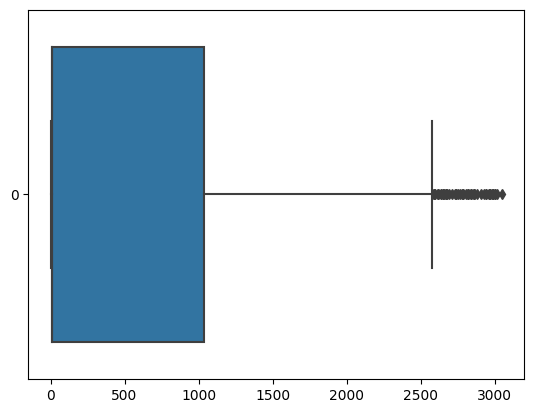

In [ ]:
sns.boxplot(df_train['Fuel Consumption City'], orient="h")

In [ ]:
# IQR
Q1 = np.percentile(df_train['Fuel Consumption City'].dropna(), 25, method='midpoint')
Q3 = np.percentile(df_train['Fuel Consumption City'].dropna(), 75, method='midpoint')
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Above Upper bound
upper_array = np.array(df_train['Fuel Consumption City'] > upper)
print("Upper Bound:", upper)
print(upper_array.sum())

#Below Lower bound
lower_array = np.array(df_train['Fuel Consumption City'] < lower)
print("Lower Bound:", lower)
print(lower_array.sum())

Upper Bound: 2587.288495575221
49
Lower Bound: -1538.8141592920351
0


In [ ]:
# IQR
Q1 = np.percentile(df_train['Fuel Consumption Hwy'].dropna(), 25, method='midpoint')
Q3 = np.percentile(df_train['Fuel Consumption Hwy'].dropna(), 75, method='midpoint')
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Above Upper bound
upper_array = np.array(df_train['Fuel Consumption Hwy'] > upper)
print("Upper Bound:", upper)
print(upper_array.sum())

#Below Lower bound
lower_array = np.array(df_train['Fuel Consumption Hwy'] < lower)
print("Lower Bound:", lower)
print(lower_array.sum())

Upper Bound: 1909.4
70
Lower Bound: -1129.0
0


In [ ]:
# IQR
Q1 = np.percentile(df_train['Fuel Consumption Comb'].dropna(), 25, method='midpoint')
Q3 = np.percentile(df_train['Fuel Consumption Comb'].dropna(), 75, method='midpoint')
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Above Upper bound
upper_array = np.array(df_train['Fuel Consumption Comb'] > upper)
print("Upper Bound:", upper)
print(upper_array.sum())

#Below Lower bound
lower_array = np.array(df_train['Fuel Consumption Comb'] < lower)
print("Lower Bound:", lower)
print(lower_array.sum())

Upper Bound: 2286.0499999999997
17
Lower Bound: -1356.75
0


# Part 2: Visualization and Gaining Insights

In [ ]:
df = df_train

In [ ]:
df

,Id,Engine Size(L),Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Make_BARUSU,Make_BMV,Make_CADILUXE,Make_CHEVO,Make_DOGE,Make_FIAR,Make_FOLD,Make_FOLKSWA,Make_GONDA,Make_JIPU,Make_KIO,Make_LAMBOGI,Make_LAND CRAWLER,Make_LECUS,Make_MATSUDA,Make_MITSU,Make_NIRRAN,Make_RYUNDAI,Make_TOLVO,Make_TOYOTI,Vehicle Class_FULL-SIZE,Vehicle Class_MID-SIZE,Vehicle Class_MINICOMPACT,Vehicle Class_MINIVAN,Vehicle Class_PICKUP TRUCK - SMALL,Vehicle Class_PICKUP TRUCK - STANDARD,Vehicle Class_SPECIAL PURPOSE VEHICLE,Vehicle Class_STATION WAGON - MID-SIZE,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Vehicle Class_nan,Cylinders_12.0,Cylinders_3.0,Cylinders_4.0,Cylinders_5.0,Cylinders_6.0,Cylinders_8.0,Cylinders_nan,Transmission_A4,Transmission_A5,Transmission_A6,Transmission_A7,Transmission_A8,Transmission_A9,Transmission_AM6,Transmission_AM7,Transmission_AM8,Transmission_AM9,Transmission_AS10,Transmission_AS5,Transmission_AS6,Transmission_AS7,Transmission_AS8,Transmission_AS9,Transmission_AV,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Transmission_nan,Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z,Fuel Type_nan
0,1.00000000,1.50000000,8.40000000,7.20000000,9.80000000,208.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000
1,2.00000000,3.50000000,7.25000000,970.00000000,1196.00000000,325.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000
2,3.00000000,2.00000000,9.80000000,13.69911504,11.24247788,170.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000

# Part 3: Feature Engineering

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54937 entries, 0 to 54936
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Id                                      54937 non-null  int64  
 1   Engine Size(L)                          49673 non-null  float64
 2   Fuel Consumption City                   52612 non-null  float64
 3   Fuel Consumption Hwy                    52374 non-null  float64
 4   Fuel Consumption Comb                   52385 non-null  float64
 5   CO2 Emissions(g/km)                     54937 non-null  int64  
 6   Make_BARUSU                             54937 non-null  uint8  
 7   Make_BMV                                54937 non-null  uint8  
 8   Make_CADILUXE                           54937 non-null  uint8  
 9   Make_CHEVO                              54937 non-null  uint8  
 10  Make_DOGE                               54937 non-null  ui

# Part 4: Modelling

<Axes: >

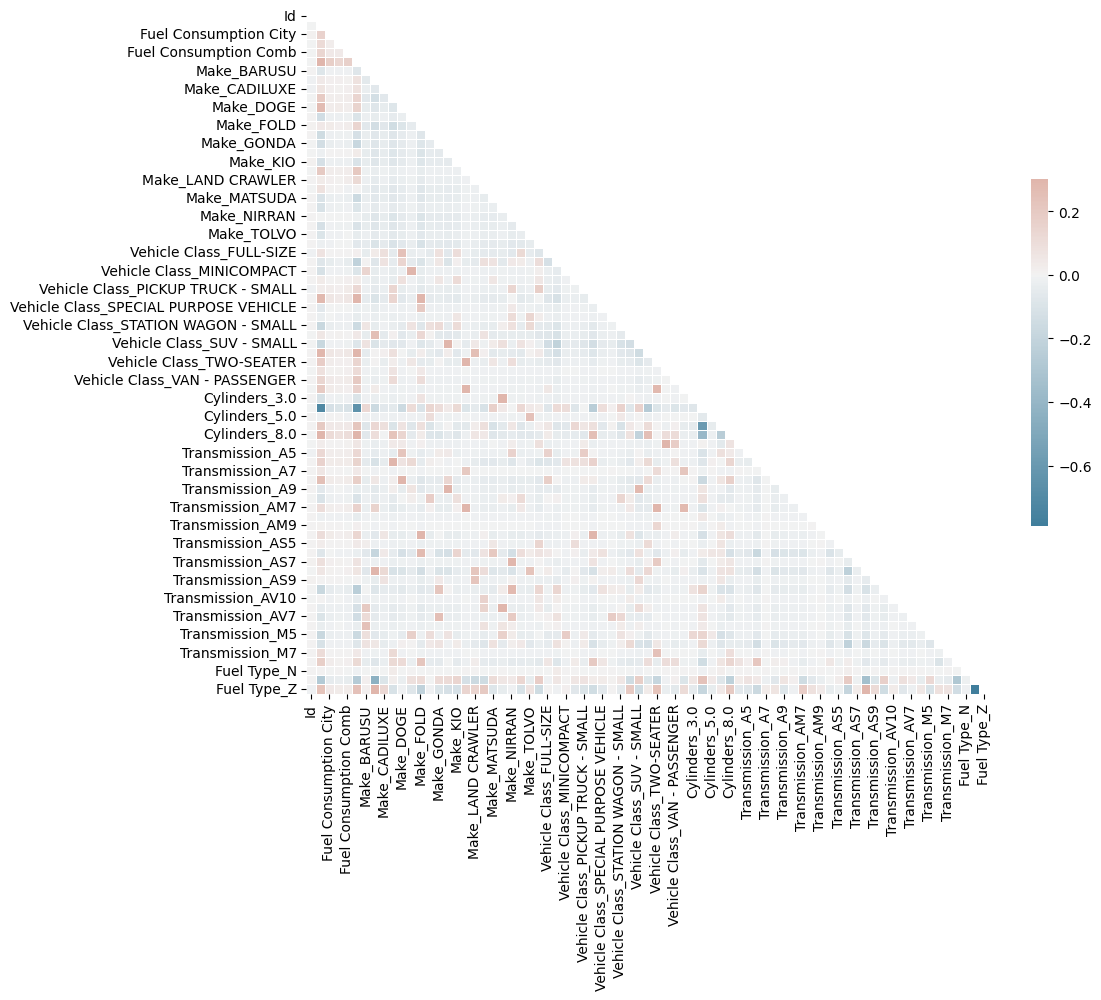

In [ ]:
num = df_train.select_dtypes(include = np.number)
corr = num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df_train.drop(columns=['Id'], axis=1, inplace=True)

df_test.drop(columns=['Id'], axis=1, inplace=True)

In [ ]:
def feature_importance_viz(df, model):

    # Assuming features is a list of column names in the order used for training
    features = df.drop(['price_mean'], axis=1).columns.tolist()

    # Get feature importances from your model
    importances = list(model.feature_importances_)

    # Create a DataFrame to make sorting easier
    importance_df = pd.DataFrame({
      'feature': features,
      'importance': importances
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert the y-axis to show the feature with the highest importance at the top
    plt.show()

In [ ]:
X_train = df_train.drop(columns = ['CO2 Emissions(g/km)'], axis=1)
y_train = df_train[['CO2 Emissions(g/km)']]

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size = 0.3, random_state = 123)

In [ ]:
highmem_regressors = [
    "GammaRegressor", "GaussianProcessRegressor", "KernelRidge", "QuantileRegressor", "NuSVR", "SVR"
]
regressors = [reg for reg in lazypredict.Supervised.REGRESSORS if reg[0] not in highmem_regressors]

In [ ]:
reg = LazyRegressor(regressors=regressors, verbose=0, ignore_warnings=False, custom_metric=None)
models,pred = reg.fit(X_train2, X_test2, y_train2, y_test2)
models

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 97%|█████████▋| 35/36 [03:47<00:02,  2.81s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 38236, number of used features: 75
[LightGBM] [Info] Start training from score 246.050371


100%|██████████| 36/36 [03:48<00:00,  6.34s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.90860000,0.90902950,20.03477526,1.57184172
RandomForestRegressor,0.90531269,0.90575764,20.39187960,44.42342901
LGBMRegressor,0.90300987,0.90346564,20.63835745,1.01204562
HistGradientBoostingRegressor,0.90239310,0.90285177,20.70387429,5.18795943
ExtraTreesRegressor,0.90084956,0.90131548,20.86693592,38.26992011
MLPRegressor,0.89687643,0.89736102,21.28091713,79.87051368
BaggingRegressor,0.89544227,0.89593360,21.42838489,4.16104031
KNeighborsRegressor,0.87786244,0.87843638,23.15986300,5.34549093
GradientBoostingRegressor,0.85346499,0.85415358,25.36775671,9.37784648


## LightGBM

In [ ]:
start=time.time()

kf = KFold(n_splits=15, shuffle=True, random_state=123)

def objective(trial):
    params = {"objective": "regression",
            "metric": "rmse",
            "boosting": "gbdt",
            "n_estimators": 1033,
            "verbosity": -1,
            "random_state": 123,
            "bagging_freq": 1,
            "bagging_seed": 123,
            "feature_selection_seed": 123,
            "max_depth": 8,
            "learning_rate": trial.suggest_float("learning_rate", 0.055, 0.0552, log=True),
            "num_leaves": 21,
            "subsample": trial.suggest_float("subsample", 0.8924, 0.8925, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.749772, 0.749774, log=True),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.141982, 0.141986, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.139204, 0.139206, log=True),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.10626, 0.106265, log=True),
            "min_data_in_leaf": 30}

    model = LGBMRegressor(**params)
    best_score = cross_val_score(model, X_train, np.ravel(y_train), scoring='neg_root_mean_squared_error', cv=kf).mean()
    return -best_score

sampler = TPESampler(seed=123)
study_lgb_gbdt = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb_gbdt.optimize(objective, n_trials=5)

end = time.time()
duration = end - start
print(f"The cell took {duration} seconds to run.")

[I 2023-12-14 06:44:42,875] A new study created in memory with name: no-name-ee03c1a5-0a9e-4db6-8f4c-1d5143a84933
[I 2023-12-14 06:45:50,494] Trial 0 finished with value: 20.12588638198002 and parameters: {'learning_rate': 0.05513921708565148, 'subsample': 0.892428612789106, 'colsample_bytree': 0.7497724537024393, 'lambda_l1': 0.1419842052451386, 'lambda_l2': 0.13920543893503975, 'min_gain_to_split': 0.10626211550358786}. Best is trial 0 with value: 20.12588638198002.
[I 2023-12-14 06:46:58,146] Trial 1 finished with value: 20.149659324035937 and parameters: {'learning_rate': 0.055196145987851206, 'subsample': 0.892468481764606, 'colsample_bytree': 0.749772961863137, 'lambda_l1': 0.14198356845664245, 'lambda_l2': 0.13920468635279382, 'min_gain_to_split': 0.1062636452253}. Best is trial 0 with value: 20.12588638198002.
[I 2023-12-14 06:48:20,034] Trial 2 finished with value: 20.15400024049512 and parameters: {'learning_rate': 0.05508762508104686, 'subsample': 0.8924059674752707, 'colsam

The cell took 400.91648268699646 seconds to run.


In [ ]:
print('Best hyperparameters:', study_lgb_gbdt.best_params)
print('Best RMSE:', study_lgb_gbdt.best_value)

Best hyperparameters: {'learning_rate': 0.05513921708565148, 'subsample': 0.892428612789106, 'colsample_bytree': 0.7497724537024393, 'lambda_l1': 0.1419842052451386, 'lambda_l2': 0.13920543893503975, 'min_gain_to_split': 0.10626211550358786}
Best RMSE: 20.12588638198002


In [ ]:
study_lgb_gbdt.trials_dataframe().sort_values('value', ascending=True).head(5)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_lambda_l1,params_lambda_l2,params_learning_rate,params_min_gain_to_split,params_subsample,state
0,0,20.12588638,2023-12-14 06:44:42.878002,2023-12-14 06:45:50.494061,0 days 00:01:07.616059,0.74977245,0.14198421,0.13920544,0.05513922,0.10626212,0.89242861,COMPLETE
3,3,20.14073433,2023-12-14 06:48:20.040888,2023-12-14 06:49:52.425657,0 days 00:01:32.384769,0.74977327,0.14198540,0.13920545,0.05510622,0.10626306,0.89245318,COMPLETE
4,4,20.14140283,2023-12-14 06:49:52.427967,2023-12-14 06:51:23.787208,0 days 00:01:31.359241,0.74977272,0.14198291,0.13920459,0.05514442,0.10626315,0.89243229,COMPLETE
1,1,20.14965932,2023-12-14 06:45:50.496879,2023-12-14 06:46:58.146182,0 days 00:01:07.649303,0.74977296,0.14198357,0.13920469,0.05519615,0.10626365,0.89246848,COMPLETE
2,2,20.15400024,2023-12-14 06:46:58.148504,2023-12-14 06:48:20.033234,0 days 00:01:21.884730,0.74977280,0.14198495,0.13920436,0.05508763,0.10626088,0.89240597,COMPLETE


In [ ]:
# Best Parameter
best_params_lgb = study_lgb_gbdt.best_params

lgb_optuna_gbdt = LGBMRegressor(objective='regression', metric='rmse', verbosity=-1,
                          bagging_freq=1, random_state=123,
                           **best_params_lgb)

print(lgb_optuna_gbdt)
lgb_optuna_gbdt.fit(X_train2, y_train2)
train_preds_lgb = lgb_optuna_gbdt.predict(X_test2)
train_rmse_lgb = np.sqrt(mse(y_test2, train_preds_lgb))

print("")
print(f"Train RMSE LightGBM: {train_rmse_lgb}")

LGBMRegressor(bagging_freq=1, colsample_bytree=0.7497724537024393,
              lambda_l1=0.1419842052451386, lambda_l2=0.13920543893503975,
              learning_rate=0.05513921708565148, metric='rmse',
              min_gain_to_split=0.10626211550358786, objective='regression',
              random_state=123, subsample=0.892428612789106, verbosity=-1)

Train RMSE LightGBM: 21.45780699712826


In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
import lightgbm as lgb
fit_params={"eval_metric" : 'auc',
            "eval_set" : [(X_test2,y_test2)],
            'eval_names': ['valid'],
            'categorical_feature': 'auto'}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

In [ ]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, silent=True,
               subsample=0.855)

In [ ]:
best_model = LGBMRegressor(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, silent=True,
               subsample=0.855)
best_model.fit(X_train2, y_train2)
train_preds_lgb = best_model.predict(X_test2)
train_rmse_lgb = np.sqrt(mse(y_test2, train_preds_lgb))

print("")
print(f"Train RMSE LightGBM: {train_rmse_lgb}")

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 38455, number of used features: 56
[LightGBM] [Info] Start training from score 246.624600
[LightGBM] [Warning] Unknown parameter: silent


ValueError: ignored

# XGBoost#

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train2, y_train2)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
Best score:  nan


In [ ]:
regressor = xgb.XGBRegressor(**grid_search.best_params_)

regressor.fit(X_train2,y_train2)
y_pred = regressor.predict(X_test2)
train_rmse_xgb = np.sqrt(mse(y_test2, y_pred))

print("")
print(f"Train RMSE LightGBM: {train_rmse_xgb}")


Train RMSE LightGBM: 24.697107890467716


In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
from sklearn.metrics import accuracy_score

def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [( X_train2, y_train2), ( X_test2, y_test2)]

    clf.fit(X_train2, y_train2,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(X_test2)
    accuracy = accuracy_score(y_test2, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

best_hyperparams = {'colsample_bytree': 0.9249260887573247, 'gamma': 8.69897781000208, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 170, 'reg_lambda': 0.6481270086582626}

The best hyperparameters are :  

{'colsample_bytree': 0.9249260887573247, 'gamma': 8.69897781000208, 'max_depth': 8.0, 'min_child_weight': 6.0, 'reg_alpha': 170.0, 'reg_lambda': 0.6481270086582626}


In [ ]:
regressor = xgb.XGBRegressor(**best_hyperparams)

regressor.fit(X_train2,y_train2)
y_pred = regressor.predict(X_test2)
train_rmse_xgb = np.sqrt(mse(y_test2, y_pred))

print("")
print(f"Train RMSE LightGBM: {train_rmse_xgb}")


Train RMSE LightGBM: 19.655441391094488


## MLPRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor()
#
# Train the model
#
nn.fit(X_train2, y_train2)

MLPRegressor()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Make prediction
pred = nn.predict(X_test2)
#
# Calculate accuracy and error metrics
#
test_set_rsquared = nn.score(X_test2, y_test2)
test_set_rmse = np.sqrt(mean_squared_error(y_test2, pred))
#
# Print R_squared and RMSE value
#
print('R_squared value: ', test_set_rsquared)
print('RMSE: ', test_set_rmse)

R_squared value:  0.8557176585056248
RMSE:  25.75682366916831


## CatBoost

In [ ]:
start=time.time()

kf = KFold(n_splits=5, shuffle=True, random_state=123)

def objective(trial):
    params = {"random_state": 123,
              "loss_function": "RMSE",
              "iterations": 1000,
              "learning_rate": trial.suggest_float("learning_rate", 0.0785554, 0.0785555, log=True),
              "depth": 7,
              "subsample": trial.suggest_float("subsample", 0.810417, 0.8104171, log=True),
              "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8212551, 0.8212552, log=True),
              "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.7833714, 0.7833715, log=True),
              "random_strength": trial.suggest_float("random_strength", 0.0787843, 0.0787845, log=True),
              "min_data_in_leaf": 31}

    model = CatBoostRegressor(**params, silent=True)
    best_score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf).mean()
    return -best_score

sampler = TPESampler(seed=123)
study_cb_ver2 = optuna.create_study(direction='minimize', sampler=sampler)
study_cb_ver2.optimize(objective, n_trials=5)

end = time.time()
duration = end - start
print(f"The cell took {duration} seconds to run.")

[I 2023-12-13 21:57:30,537] A new study created in memory with name: no-name-c19aca93-df4c-4a12-aeb8-0fdb87389ae7
[I 2023-12-13 21:58:38,396] Trial 0 finished with value: 19.449109029016068 and parameters: {'learning_rate': 0.0785554696469051, 'subsample': 0.8104170286139323, 'colsample_bylevel': 0.8212551226851443, 'l2_leaf_reg': 0.7833714551314753, 'random_strength': 0.0787844438937427}. Best is trial 0 with value: 19.449109029016068.
[I 2023-12-13 21:59:31,133] Trial 1 finished with value: 19.44910919250043 and parameters: {'learning_rate': 0.0785554423106305, 'subsample': 0.8104170980764197, 'colsample_bylevel': 0.8212551684829725, 'l2_leaf_reg': 0.7833714480931886, 'random_strength': 0.07878437842344314}. Best is trial 0 with value: 19.449109029016068.
[I 2023-12-13 22:00:24,357] Trial 2 finished with value: 19.449109233282996 and parameters: {'learning_rate': 0.07855543431778726, 'subsample': 0.8104170729049696, 'colsample_bylevel': 0.821255143857223, 'l2_leaf_reg': 0.78337140596

KeyboardInterrupt: ignored

In [ ]:
print('Best hyperparameters:', study_cb_ver2.best_params)
print('Best RMSE:', study_cb_ver2.best_value)

In [ ]:
study_cb_ver2.trials_dataframe().sort_values('value', ascending=True).head(5)

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study_cb_ver2)

RuntimeError: ignored

In [ ]:
optuna.visualization.plot_slice(study_cb_ver2)

In [ ]:
optuna.visualization.plot_optimization_history(study_cb_ver2)

In [ ]:
# Best Parameter
best_params_cb = study_cb_ver2.best_params

cb2 = CatBoostRegressor(random_state = 123, **best_params_cb, silent=True)

cb2.fit(X_train2, y_train2)
train_preds_cb2 = cb2.predict(X_train2)
train_rmse_cb2 = np.sqrt(mse(y_train2, train_preds_cb2))

print(cb2.get_params())
print("")
print(f"Train RMSE CatBoost: {train_rmse_cb2}")

## HistGradientBoostingRegressor

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
# define the model
hgb = HistGradientBoostingRegressor()

In [ ]:
hgb.fit(X_train2, y_train2)

pred = hgb.predict(X_test2)

test_set_rsquared = hgb.score(X_test2, y_test2)
test_set_rmse = np.sqrt(mean_squared_error(y_test2, pred))
#
# Print R_squared and RMSE value
#
print('R_squared value: ', test_set_rsquared)
print('RMSE: ', test_set_rmse)

# RandomForest #

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# define the model
rf = RandomForestRegressor()
rf.fit(X_train2, y_train2)

pred = rf.predict(X_test2)

In [ ]:
train_rmse_rf = np.sqrt(mse(y_test2, pred))

#print(rf.get_params())
print("")
print(f"Train RMSE Random Forest: {train_rmse_rf}")


Train RMSE Random Forest: 19.785615664054973


# Part 5: Prediction

## Cleaning Test

In [ ]:
df_test.isna().sum()

Make                       0
Vehicle Class            219
Engine Size(L)           632
Cylinders                506
Transmission             163
Fuel Type                221
Fuel Consumption City    684
Fuel Consumption Hwy     721
Fuel Consumption Comb    688
dtype: int64

In [ ]:
df_test.isna().sum()/len(df_train)*100

Make                    0.00000000
Vehicle Class           0.39863844
Engine Size(L)          1.15040865
Cylinders               0.92105503
Transmission            0.29670350
Fuel Type               0.40227897
Fuel Consumption City   1.24506253
Fuel Consumption Hwy    1.31241240
Fuel Consumption Comb   1.25234359
dtype: float64

In [ ]:
fuel_dict = {'-1': '0',
             'zero': '0',
             '-9999': '0.',
             '9999': '0',
             'not-available': '0',
             '0': '0',
             r',': '.',
             np.nan:"0"}

def prepro_fuel(df, col):
    df[col].fillna('0.0 km/l', inplace=True)
    df[col] = df[col].str.lower()
    df[col].replace(fuel_dict, regex = True, inplace = True)
    df[[col, 'Satuan ' + col]] = df[col].str.extract(r'([\d.]+)\s*(.*)')

fuel = ['Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']
for i in fuel:
    prepro_fuel(df_test, i)

In [ ]:
def to_float_column(df, col):
    df[col] = df[col].astype(float)

for i in fuel:
    to_float_column(df_test, i)

In [ ]:
satuan_dict = {"" : 'l/100km',
               'liters per 100 km':'l/100km',
               'l/100 km': 'l/100km',
               'km per l': 'km/l'}

def prepro_satuan(df, col):
    df[col].replace(satuan_dict, regex = True, inplace = True)

satuan = ['Satuan Fuel Consumption City', 'Satuan Fuel Consumption Hwy', 'Satuan Fuel Consumption Comb']
for i in satuan:
    prepro_satuan(df_test, i)

In [ ]:
#standarisasi ke km/L semua
## 1 l/100km = 100 km/L
## 1 l/10km = 10 km/l
## 1 mpg (as) = 0.42517006802721 km/l
## 1 mpg imp. = 0.35398230088496 km/l

def convert_fuel_consumption(df):
    conversion_factors = {
        'l/100km': 100,
        'l/10km': 10,
        r'mpg (as)': 0.42517006802721,
        r'mpg imp.': 0.35398230088496}

    columns_to_convert = ['Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']

    for unit, factor in conversion_factors.items():
        for column in columns_to_convert:
            mask = df[f'Satuan {column}'] == unit
            df.loc[mask, column] *= factor

convert_fuel_consumption(df_test)

In [ ]:
for i in fuel:
    del df_test[f'Satuan ' + i]

In [ ]:
df_test.head()

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
0,FOLD,PICKUP TRUCK - STANDARD,5.0,8.0,AS10,X,1420.00000000,1520.00000000,6.82823129
1,BMV,COMPACT,2.0,4.0,A8,Z,910.00000000,15.38407080,12.61054422
2,JIPU,SUV - SMALL,1.3,4.0,A9,X,9.80176991,780.00000000,912.00000000
3,LECUS,SUV - SMALL,not-recorded,4.0,AS6,Z,0.00000000,11.23724490,0.00000000
4,BARUSU,COMPACT,2.0,unestablished,M6,Z,11.36000000,14.08495575,804.00000000


### Vehicle Class

In [ ]:
vehicle_class = {
    'missing': np.nan,
    'not-recorded': np.nan,
    'na': np.nan,
    'unspecified': np.nan,
    'unknown': np.nan,
    'unspecified': np.nan,
    'not-available': np.nan,
    '-1': np.nan,
    'unestablished': np.nan}
df_test['Vehicle Class'].replace(vehicle_class, regex = True, inplace = True)

In [ ]:
df_test['Vehicle Class'].unique().tolist()

['PICKUP TRUCK - STANDARD',
 'COMPACT',
 'SUV - SMALL',
 'TWO-SEATER',
 'SUV - STANDARD',
 'MID-SIZE',
 nan,
 'FULL-SIZE',
 'SUBCOMPACT',
 'STATION WAGON - SMALL',
 'VAN - PASSENGER',
 'PICKUP TRUCK - SMALL',
 'SPECIAL PURPOSE VEHICLE',
 'MINIVAN',
 'MINICOMPACT',
 'VAN - CARGO',
 'STATION WAGON - MID-SIZE']

### Engine Size(L)

In [ ]:
engine_size = {
    'unspecified': np.nan,
    'missing': np.nan,
    'not-recorded': np.nan,
    'not-available': np.nan,
    'unknown': np.nan,
    'unestablished': np.nan,
    'na': np.nan,
    '-1': np.nan}
df_test['Engine Size(L)'].replace(engine_size, regex = True, inplace = True)
df_test['Engine Size(L)'] = df_test['Engine Size(L)'].astype(float)

In [ ]:
df_test['Engine Size(L)'].unique().tolist()

[5.0,
 2.0,
 1.3,
 nan,
 6.2,
 1.8,
 4.4,
 1.6,
 2.4,
 3.0,
 1.4,
 6.0,
 5.2,
 3.5,
 3.3,
 2.5,
 2.3,
 3.2,
 3.6,
 3.8,
 1.0,
 4.8,
 2.8,
 2.7,
 5.6,
 1.5,
 5.3,
 5.8,
 6.6,
 5.7,
 6.4,
 8.4,
 4.6,
 5.4,
 3.7,
 4.0,
 1.2,
 4.3,
 6.5,
 3.4,
 6.8,
 2.2,
 4.2]

### Cylinders

In [ ]:
cyl = {
    'not-available': np.nan,
    'unestablished': np.nan,
    'unspecified': np.nan,
    'not-recorded': np.nan,
    '-1': np.nan,
    'missing': np.nan,
    'unknown': np.nan,
    'na': np.nan}
df_test['Cylinders'].replace(cyl, regex = True, inplace = True)

In [ ]:
df_test['Cylinders'].unique().tolist()

['8.0', '4.0', nan, '10.0', '6.0', '3.0', '12.0', '5.0']

### Transmission

In [ ]:
transmission = {
    'unspecified': np.nan,
    'not-recorded': np.nan,
    'unknown': np.nan,
    'missing': np.nan,
    'not-available': np.nan,
    'na': np.nan,
    '-1': np.nan,
    'unestablished': np.nan}
df_test['Transmission'].replace(transmission, regex = True, inplace = True)

In [ ]:
df_test['Transmission'].unique().tolist()

['AS10',
 'A8',
 'A9',
 'AS6',
 'M6',
 'M7',
 'AS8',
 'A6',
 'AM7',
 'M5',
 'AS9',
 'AV7',
 'AV6',
 nan,
 'AV',
 'AM6',
 'A5',
 'AS7',
 'A4',
 'AV8',
 'AS5',
 'A10',
 'AM8',
 'AV10',
 'AM9',
 'A7']

### Fuel Type

In [ ]:
fuel_type = {
    '-1': np.nan,
    'missing': np.nan,
    'unspecified': np.nan,
    'unknown': np.nan,
    'not-recorded': np.nan,
    'unestablished': np.nan,
    'not-available': np.nan,
    'na': np.nan}
df_test['Fuel Type'].replace(fuel_type, regex = True, inplace = True)

In [ ]:
df_test['Fuel Type'].unique().tolist()

['X', 'Z', 'D', nan, 'E', 'N']

In [ ]:
df_test

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
0,FOLD,PICKUP TRUCK - STANDARD,5.00000000,8.0,AS10,X,1420.00000000,1520.00000000,6.82823129
1,BMV,COMPACT,2.00000000,4.0,A8,Z,910.00000000,15.38407080,12.61054422
2,JIPU,SUV - SMALL,1.30000000,4.0,A9,X,9.80176991,780.00000000,912.00000000
3,LECUS,SUV - SMALL,NaN,4.0,AS6,Z,0.00000000,11.23724490,0.00000000
4,BARUSU,COMPACT,2.00000000,NaN,M6,Z,11.36000000,14.08495575,804.00000000
...,...,...,...,...,...,...,...,...,...
23540,MITSU,SUV - SMALL,2.00000000,4.0,M5,X,0.00000000,13.33000000,898.00000000
23541,CHEVO,COMPACT,1.40000000,4.0,M6,X,11.49659864,18.18000000,7.30000000
23542,KIO,SUV - SMALL,NaN,4.0,AS6,X,1160.00000000,840.00000000,9.84000000
23543,JIPU,SUV - SMALL,2.40000000,4.0,A9,X,9.52000000,8.40000000,9.60000000


In [ ]:
def prepro_null(df, col):
    df[col].replace(0.0, np.nan, inplace = True)

fuel = ['Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']
for i in fuel:
    prepro_null(df_test, i)

In [ ]:
df_test = pd.get_dummies(df_test, columns=['Make'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Vehicle Class'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Cylinders'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Transmission'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Fuel Type'], drop_first=True)

In [ ]:
# Impute missing values using IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)

# If you need to recover the original column names
df_test_imputed.columns = df_test.columns.tolist()

In [ ]:
df_test = df_test_imputed

In [ ]:
df_train.to_csv('Data Train (Imputed).csv', index=False)
df_test.to_csv('Data Test (Imputed).csv', index=False)

## Submission

In [ ]:
submission = regressor.predict(df_test)

index = np.arange(54938, 78483)

df_submission = pd.DataFrame({'Id': index, 'CO2 Emissions(g/km)': submission})

df_submission.to_csv('submission (XGB).csv', index=False)

In [ ]:
import pickle

pickle.dump(regressor, open('Model_Ben10.pkl', 'wb'))